# Part 1. Camera calibration

Using the photos taken with the camera and the 9x6 chessboard we extract the calibration coefficients k1,k2,k3 and save in a Python serializable object

In [1]:
#Most of this code was commited to https://github.com/udacity/CarND-Camera-Calibration by Ryan Keenan.

import  numpy  as  np
import  cv2
import  glob
import  matplotlib.pyplot  as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
valids = 0
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        valids += 1
print ("Camera calibration finished. Found "+str(valids)+ " chessboard images out of "+str(len(images))+" provided files.")


Camera calibration finished. Found 17 chessboard images out of 20 provided files.


Text(0.5,1,'Undistorted Image')

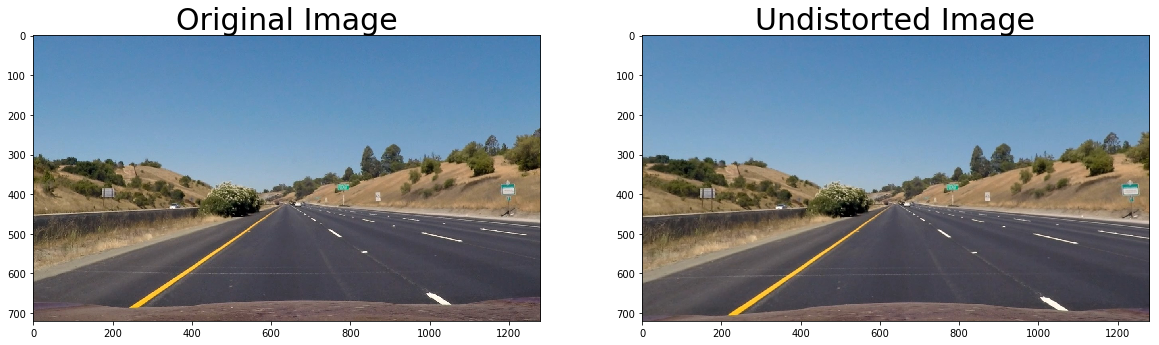

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
originalimg = cv2.imread('./test_images/straight_lines1.jpg')
img_size = (originalimg.shape[1], originalimg.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


undistorted = cv2.undistort(originalimg, mtx, dist, None, mtx)
cv2.imwrite('./output/test_undist1.jpg',undistorted)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
originalimg = cv2.cvtColor(originalimg, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(originalimg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

In [3]:
def undistort_camera (img, calibration_data_file):
    dist_pickle = pickle.load( open( calibration_data_file, "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    img_size = (img.shape[1], img.shape[0])
    return cv2.undistort(img, mtx, dist, None, mtx)


# Part 2, birds-eye perspective 

I have read that you can do fixing two points at top of image (farthest distance from camera) or two points at bottom (nearest points respect of camera). 

If you warp fixing the bottom points, seems that you add spacial resolution without increasing the information, so the gradient change detection algorithms performance is worse.

See https://nikolasent.github.io/opencv/2017/05/07/Bird's-Eye-View-Transformation.html

The trick here is to play with straight lanes picture. Birds-eye transformed should be straight too, if not we have distorted the lanes.

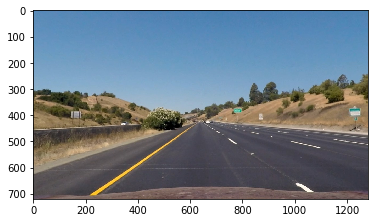

In [4]:
plt.imshow(undistorted) # Show results
plt.show()

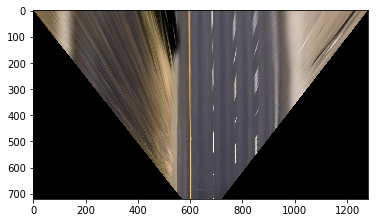

In [5]:
sourcepoints = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
destinationpoints = np.float32([[569, 720], [711, 720], [0, 0], [1280, 0]])
img_size = (10000,10000)

M = cv2.getPerspectiveTransform(sourcepoints, destinationpoints)
Minv = cv2.getPerspectiveTransform(destinationpoints, sourcepoints)

def warp_birds_eye (image,sourcepoints,destinationpoints, inv = False):
    #img_size = (image.shape[1], image.shape[0])
    img_size = (1280,720)
    M = cv2.getPerspectiveTransform(sourcepoints, destinationpoints)
    Minv = cv2.getPerspectiveTransform(destinationpoints, sourcepoints)
    if (inv==False):
        return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        img_size = (1280, 720)
        return cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
            
warped = warp_birds_eye(undistorted,sourcepoints,destinationpoints,False)
plt.imshow(warped) # Show results
plt.show()

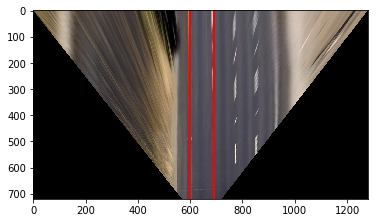

In [6]:
vertical_lines = np.copy(warped)
cv2.line(vertical_lines,(600,0),(600,720),(255,0,0),5)
cv2.line(vertical_lines,(690,0),(690,720),(255,0,0),5)
plt.imshow(vertical_lines) # Show results
plt.show()

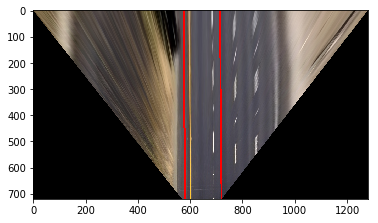

In [7]:
vertical_lines2 = np.copy(warped)
cv2.line(vertical_lines2,(576,0),(580,720),(255,0,0),5)
cv2.line(vertical_lines2,(714,0),(720,720),(255,0,0),5)
plt.imshow(vertical_lines2) # Show results
plt.show()

So, 90px are the wide of the lane (3.7 meters wide) and the suggested relationship of "30/720 # meters per pixel in y dimension" fits perfectly.  

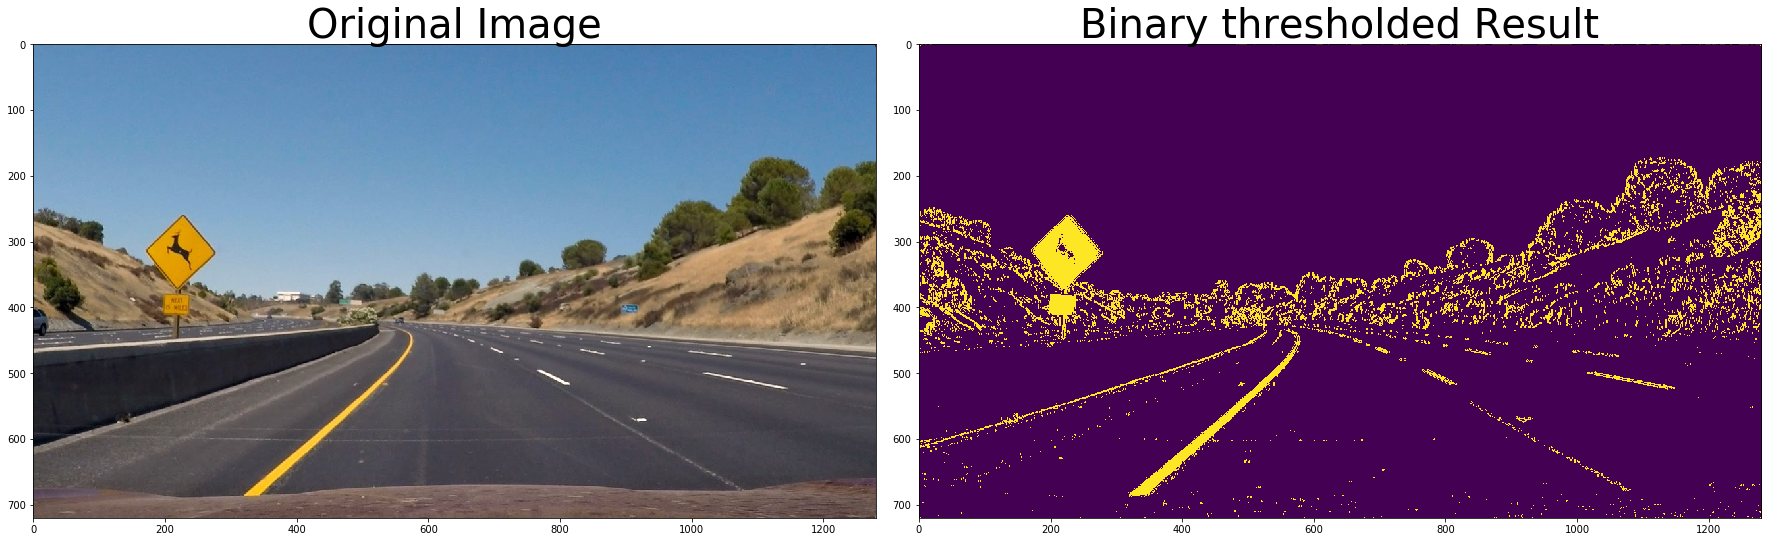

In [19]:

def sobel_schannel_thresholds(img, s_thresh=(180, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary


import matplotlib.image as mpimg

curved =  mpimg.imread('./test_images/test2.jpg')  
#curved = cv2.cvtColor(curved, cv2.COLOR_BGR2RGB)
binary = sobel_schannel_thresholds(curved)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(curved)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary)
ax2.set_title('Binary thresholded Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

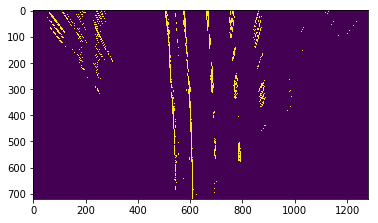

In [9]:
binary_warped = warp_birds_eye(binary,sourcepoints,destinationpoints)

plt.imshow(binary_warped) # Show results
plt.show()

# Part 3, detecting lane lines

## Thresholding in different colour spaces

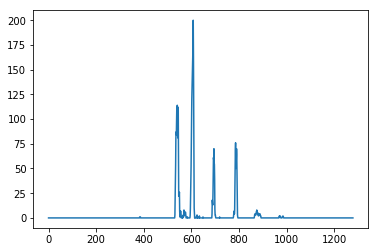

In [10]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)


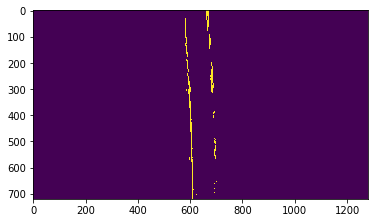

In [11]:
#From previous work 

vertices = np.array([[(580,720),(580,0),(720,0),(720,720)]], dtype=np.int32)
vertices2 = np.array([[(580,720),(580,400),(720,400),(720,720)]], dtype=np.int32)
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

binary_warped_cut = region_of_interest(binary_warped,vertices)
plt.imshow(binary_warped_cut)
#vertices = np.array([[(0,imshape[0]),(470, 300), (505, 300), (imshape[1],imshape[0])]], dtype=np.int32)


In [23]:
def find_lanes_sliding_window(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 100
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 20
    # Set minimum number of pixels found to recenter window
    minpix = 12
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    return (leftx, rightx, lefty,righty,ploty,left_fit,right_fit,out_img)

#find_lanes_sliding_window(binary_warped_cut)

In [24]:

def find_lanes_from_poly(img,left_fit,right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return (left_fitx,right_fitx)

In [14]:

def pipeline_adv_lane_lines_finding (img, calibration_data_file):
    
    
    
    #1. Distortion correction
    img = undistort_camera (img, calibration_data_file)
    original = img
    
    #2. Color/gradient threshold
    img = sobel_schannel_thresholds(img)
    
    #3. Perspective transform
    src = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
    dst = np.float32([[569, 720], [711, 720], [0, 0], [1280, 0]])
    #src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    #dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    img = warp_birds_eye(img,src,dst,False)
    
    #4. Region of interest
    
    vertices = np.array([[(580,720),(580,0),(720,0),(720,720)]], dtype=np.int32)
    #vertices = np.array([[(580,720),(580,300),(720,300),(720,720)]], dtype=np.int32)
    img =region_of_interest(img, vertices) 
    
    #5. Find lanes lines
    
    leftx, rightx ,lefty,righty,ploty,left_fit,right_fit,out_img = find_lanes_sliding_window(img)
    
    #6. Compute radius
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radio of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius = (left_curverad + right_curverad)/2
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    #7. Draw on original 
    
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(original).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp to real world
    newwarp = warp_birds_eye(color_warp,src,dst,True) 
    final = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    #plt.imshow(final)
    
    #Offset computing, our lanes detect start at y=673 pixels to avoid car hood, so we evaluate polynomies at 673
    
    leftlane_nearcar = left_fit_cr[0]*720**2 + left_fit_cr[1]*720 + left_fit_cr[2]
    rightlane_nearcar = right_fit_cr[0]*720**2 + right_fit_cr[1]*720 + right_fit_cr[2]
    
    offset = (((1280/2)*xm_per_pix)  - ((leftlane_nearcar + rightlane_nearcar)/2))* xm_per_pix
    return final,radius,offset

#pipeline_adv_lane_lines_finding (cv2.cvtColor(cv2.imread('./test_images/test2.jpg'), cv2.COLOR_BGR2RGB), "wide_dist_pickle.p")

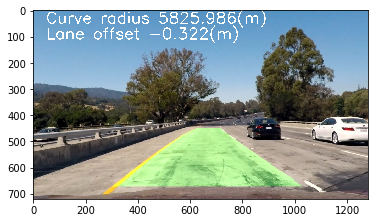

In [15]:
def video_pipeline(img):
    result,radio,lane_offset = pipeline_adv_lane_lines_finding(img,"wide_dist_pickle.p")
    #print on video frames the info
    cv2.putText(result, 'Curve radius {:.3f}(m)'.format(radio), (50,50),cv2.FONT_HERSHEY_SIMPLEX , fontScale = 2, color=(255,255,255), thickness = 3)
    cv2.putText(result, 'Lane offset {:.3f}(m)'.format(lane_offset), (50,110),cv2.FONT_HERSHEY_SIMPLEX , fontScale = 2, color=(255,255,255), thickness = 3)

    return result
plt.imshow(video_pipeline(cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)))

In [16]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    return video_pipeline(image)

lanes_detect = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(lanes_detect, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:54<00:00,  7.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 2min 55s


In [18]:
lanes_detect_challenge = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("./challenge_video.mp4")
challenge = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge.write_videofile(lanes_detect_challenge, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:05<00:00,  7.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 1min 6s
